In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("..")
from analysis.snoRNA.utils_arcs import plot_arcs_from_list
from analysis.snoRNA.find_snoRNA_peaks import load_bigWig

### 28S

In [2]:
f_pdb = "../analysis/validation/pdb/anger/anger_28S_rRNA_phosphate.txt"

In [3]:
def euclidean_dist(x, y):
    return np.sqrt(((x - y)**2).sum())

coords = {}
with open(f_pdb, "r") as f:
    for line in f:
        row = line.strip("\r\n").split("\t")
        nid, x, y, z = int(row[0]), float(row[1]), float(row[2]), float(row[3])
        coords[nid] = [[x, y, z]]

In [4]:
data = np.zeros((5071, 5071))
for no1, (k1, v1) in enumerate(coords.items()):
    for no2, (k2, v2) in enumerate(coords.items()):

        centroid1 = np.array(v1).mean(axis=0)
        centroid2 = np.array(v2).mean(axis=0)

        data[k1][k2] = euclidean_dist(centroid1, centroid2)

### 18S

In [5]:
f_pdb = "../analysis/validation/pdb/anger/anger_18S_rRNA_phosphate.txt"

In [6]:
coords = {}
with open(f_pdb, "r") as f:
    for line in f:
        row = line.strip("\r\n").split("\t")
        nid, x, y, z = int(row[0]), float(row[1]), float(row[2]), float(row[3])
        coords[nid] = [[x, y, z]]

In [7]:
data_18S = np.zeros((1870, 1870))
for no1, (k1, v1) in enumerate(coords.items()):
    for no2, (k2, v2) in enumerate(coords.items()):

        centroid1 = np.array(v1).mean(axis=0)
        centroid2 = np.array(v2).mean(axis=0)

        data_18S[k1][k2] = euclidean_dist(centroid1, centroid2)

### Scale and Normalize

In [10]:
f_list = "../analysis/snoRNA/data_multi/hcanonical_v2/G1_kethoxal-HepG2_M13_R01_abundance.txt"
f_bw = "../analysis/snoRNA/data_multi/hcanonical_v2/G1_kethoxal-HepG2_M13_R01.bigWig"

datum, list_of_snoRNA = load_bigWig(f_list, f_bw)

list_of_coords = list(range(3660, 5527)) + list(range(7933, 13008))  # only 18S and 28S regions
datum = datum[:,list_of_coords]

scaled = (datum.T/datum.sum(axis=1)).T
normed = scaled - scaled.mean(axis=0)

scaled.shape, normed.shape

((114, 6942), (114, 6942))

In [11]:
dict_snoRNA = dict([ (snoRNA.split("+")[0].split("-")[1], no) for no, snoRNA in enumerate(list_of_snoRNA) ])

In [12]:
dict_known = {}
with open("../analysis/snoRNA/known_loci_SNORD.csv") as f:
    for no, line in enumerate(f):
        if no == 0:
            continue
        row = line.strip("\r\n").split(",")
        iid, locus_18S, locus_28S = row[0], int(row[1]), int(row[2])
        dict_known[iid] = (locus_18S, locus_28S)

In [13]:
from scipy.signal import find_peaks

def plot_snoRNA(profile, p_threshold=30, p_min=0, p_figax=None):

    p_width = 25

    # Balanced
    peaks, properties = find_peaks(profile, width=10, distance=50, height=0.0003)

    # Relaxed
    #peaks, properties = find_peaks(profile, width=10, distance=50, height=0.0002)

    if p_figax is None:
        fig, ax = plt.subplots(figsize=(12, 2))
    else:
        fig, ax = p_figax
    
    ax.plot(profile, color="black")

    ylim_min, ylim_max = ax.get_ylim()
    ylim_interval = (ylim_max-ylim_min)/5

    for no, peak in enumerate(peaks):
        ax.axvspan(peak-0.5-p_width, peak+0.5+p_width, color="salmon", alpha=0.3)

        ax.annotate(peak, (peak+5, ylim_max-(1*ylim_interval)))
    
    return fig, ax

def plot_proximity(p_snoRNA, p_anchor, data, p_min=0, p_max=50, p_category="28S", p_novel=False):

    p_index = dict_snoRNA[p_snoRNA]

    fig, ax = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [4, 2]}, sharex=True)
    
    p_offset = 0
    if p_category == "18S":
        profile = normed[p_index,:1867]
    elif p_category == "28S":
        profile = normed[p_index,1867:]

    proximals = np.where((data[p_anchor] > p_min) & (data[p_anchor] <= p_max))[0]
    list_of_coords = [ (p_anchor+p_offset, proximal+p_offset) if p_anchor < proximal else (proximal+p_offset, p_anchor+p_offset) for proximal in proximals ]

    plot_snoRNA(profile, p_threshold=p_max, p_figax=(fig, ax[1]))
    plot_arcs_from_list(list_of_coords, p_figax=(fig, ax[0]))

    for i in range(2):
        ax[i].axvline(p_anchor, linestyle="--", linewidth=0.5, color="black")

    ylim_min, ylim_max = ax[0].get_ylim()
    ylim_interval = (ylim_max-ylim_min)/5
    ax[0].annotate(p_anchor, (p_anchor, ylim_max-(ylim_interval)))

    if p_novel:
        ax[0].set_title("All proximal %s Ribosomal Loci within %s Angstrom of novel %s Mod Site" % (p_category, p_max, p_snoRNA))
    else:
        ax[0].set_title("All proximal %s Ribosomal Loci within %s Angstrom of known %s Mod Site" % (p_category, p_max, p_snoRNA))
    
    ax[1].set_title("KARR-seq: Predicted interaction between %s and %s rRNA (in Pink)" % (p_snoRNA, p_category))
    ax[1].set_xlim(0-5, profile.shape[0]+5)
    ax[1].set_xlabel("Position")
    ax[1].set_ylabel("Normalized Frequency")

    ax[0].axes.yaxis.set_visible(False)

### Selected Plots
#### SNORD25-18S

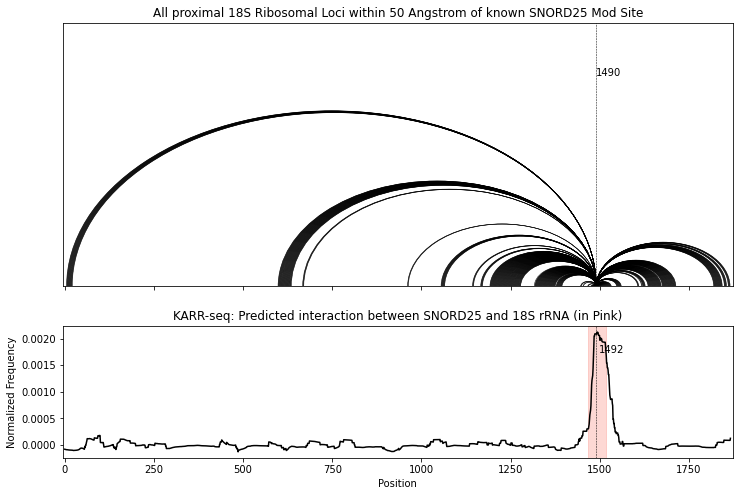

In [14]:
sno = "SNORD25"
plot_proximity(sno, dict_known[sno][0], data_18S, p_category="18S", p_max=50)

#### SNORD65-18S

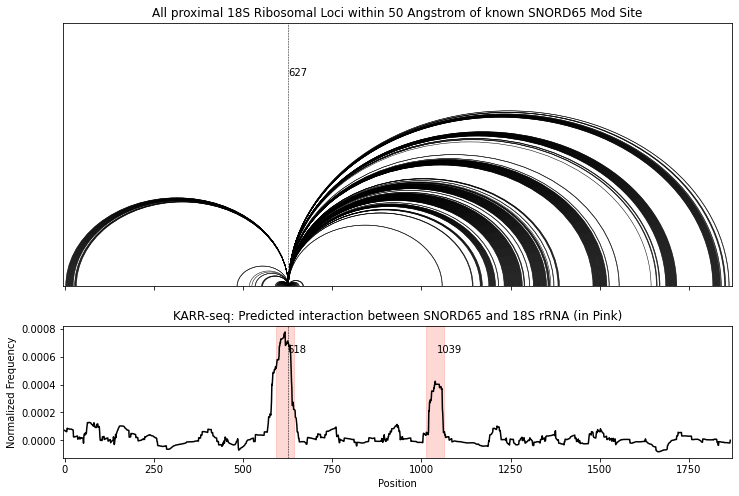

In [15]:
sno = "SNORD65"
plot_proximity(sno, dict_known[sno][0], data_18S, p_category="18S", p_max=50)